# LSTM (Long-Short term memory) from scratch in python

## Architecture

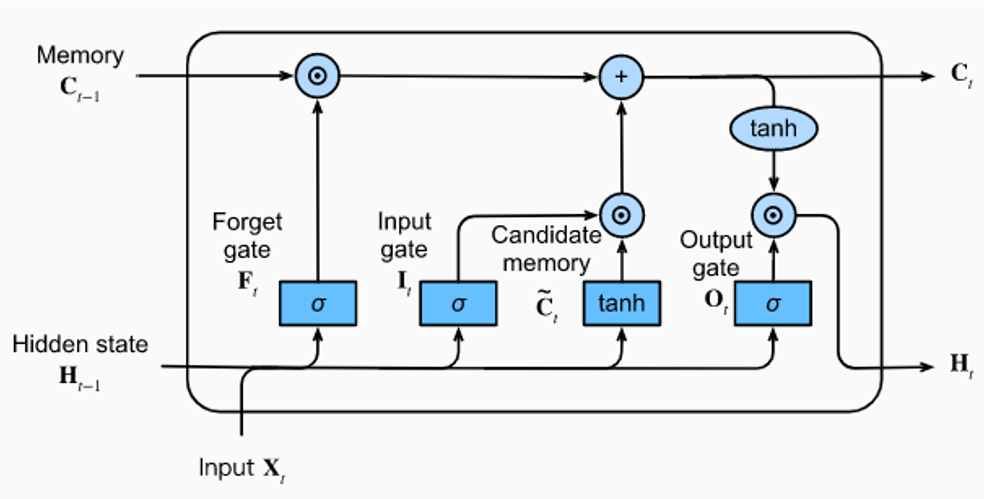

c_t - cell state (long-term memory)

h_t - hidden state (short-term memory)

### Setup

In [401]:
import torch
import matplotlib.pyplot as plt
import os
import random
from torch.utils.data import Dataset , DataLoader

In [402]:
# import wandb
# !wandb login

In [403]:
def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [404]:
from dataclasses import dataclass

@dataclass
class ModelArgs():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    no_of_neurons = 32
    batch_size = 32
    dropout = 0.1
    max_lr = 1e-4
    epochs = 100
    embedding_dim = 16
    ht_size = no_of_neurons
    ct_size = no_of_neurons
    early_stop_patience = 3

In [405]:
torch.set_default_device(ModelArgs.device)

In [406]:
num_samples = 10000
seq_length = ModelArgs.batch_size
device = ModelArgs.device

t = torch.linspace(0,100,num_samples+seq_length,device=device) # we added seq_length because -> we are creating the time series data so that after creating we got num_samples of data
data = torch.sin(t) 
# data += torch.randint(low=0,
#                       high=1,
#                       size=t.shape) # adding noise to data

# data += torch.randn(t.shape)

X_tensor = torch.stack([data[i:i+seq_length] for i in range(num_samples)]) # there is still one value not taken into account into X_tensor and it taken as next value in y_tensor
y_tensor = data[seq_length:]

train_size = int(0.8*num_samples)

X_train,y_train = X_tensor[:train_size],y_tensor[:train_size]
X_test,y_test = X_tensor[train_size:],y_tensor[train_size:]


In [407]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

(torch.Size([8000, 32]),
 torch.Size([8000]),
 torch.Size([2000, 32]),
 torch.Size([2000]))

In [408]:
class TimeSeriesData(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
    
train_dataset = TimeSeriesData(X_train,y_train)
val_dataset = TimeSeriesData(X_test,y_test)

generator = torch.Generator(device=ModelArgs.device).manual_seed(42)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=ModelArgs.batch_size,
                              shuffle=True,
                              generator=generator,
                              drop_last=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=ModelArgs.batch_size,
                            shuffle=True,
                            generator=generator,
                            drop_last=True)



### Forget Gate in LSTM

```python
f_t = sigma(w_t * [h_t,x_t]+b_t)
c_t * f_t
```

In [409]:
import torch.nn as nn
class ForgetGate(nn.Module):
    def __init__(self,h_t_size,embedding_dim):
        super(ForgetGate,self).__init__()
        
        self.sigma_nn = nn.Sequential(
            nn.Linear(in_features=h_t_size+embedding_dim , out_features=h_t_size),
            nn.Sigmoid()
        )
        
        
        
    def forward(self,h_t,X_t):
        combined = torch.cat([h_t,X_t],dim=1)
        f_t = self.sigma_nn(combined)
        return f_t

### Input Gate

```python
candidate_cell_state = tanh(W_c[h_t,x_t]+b_c)
i_t = sigma(w_i[h_t,x_t]+w_i)

c_t + (i_t * candidate_cell_state)


```

In [410]:
class InputGate(nn.Module):
    def __init__(self,h_t_size,embedding_dim):
        super(InputGate,self).__init__()
        
        self.sigma_nn = nn.Sequential(
            nn.Linear(in_features=h_t_size+embedding_dim,out_features=h_t_size),
            nn.Sigmoid()
        )
        
        self.tanh_nn = nn.Sequential(
            nn.Linear(in_features=h_t_size+embedding_dim,out_features=h_t_size),
            nn.Tanh()
        )
        
    def forward(self,h_t,X_t):
        combined = torch.cat([h_t,X_t],dim=1)
        
        i_t = self.sigma_nn(combined)
        candidate_cell_state = self.tanh_nn(combined)
        
        c_t_dash = i_t * candidate_cell_state
        
        return c_t_dash
    

## Ouput gate

```python
o_t = sigma(w_o[h_t,x_t]+b_o)
h_t = tanh(c_t) * o_t

```

In [411]:
class OutputGate(nn.Module):
    def __init__(self,h_t_size,embedding_dim):
        super(OutputGate,self).__init__()
        
        self.sigma_nn = nn.Sequential(
            nn.Linear(in_features=h_t_size+embedding_dim , out_features=h_t_size),
            nn.Sigmoid()
        )
        
    def forward(self,h_t,X_t):
        combined = torch.cat([h_t,X_t],dim=1)
        
        o_t = self.sigma_nn(combined)
        
        return o_t

### LSTM single cell

In [412]:
class LSTMCell(nn.Module):
    def __init__(self,h_t_size,embedding_dim):
        super(LSTMCell,self).__init__()
        
        self.forget_gate = ForgetGate(h_t_size=h_t_size,
                                      embedding_dim=embedding_dim)
        
        self.input_gate = InputGate(h_t_size=h_t_size,
                                    embedding_dim=embedding_dim)
        
        self.output_gate = OutputGate(h_t_size=h_t_size,
                                      embedding_dim=embedding_dim)
        
    def forward(self,X_t,h_t,c_t):
        combined = torch.cat([h_t,X_t],dim=1)
            
        f_t = self.forget_gate(h_t,X_t)
        
        c_t = c_t * f_t
        
        c_t_dash = self.input_gate(h_t,X_t)
        
        c_t = c_t + c_t_dash
        
        o_t = self.output_gate(h_t,X_t)
        
        h_t = torch.tanh(c_t) * o_t
        
        return h_t,c_t
        
        

In [413]:
# lstm = LSTMCell(h_t_size=ModelArgs.ht_size,embedding_dim=ModelArgs.embedding_dim)

In [414]:

h_t_0 = torch.zeros(size=[ModelArgs.batch_size,ModelArgs.ht_size])
c_t_0 = torch.zeros(size=[ModelArgs.batch_size,ModelArgs.ht_size])


In [415]:
class LSTMModel(nn.Module):
    def __init__(self,h_t_size,embedding_dim):
        super(LSTMModel,self).__init__()
        
        self.embedding_layer = nn.Linear(in_features=1,out_features=embedding_dim)
        self.lstm_cell = LSTMCell(h_t_size=h_t_size,
                                  embedding_dim=embedding_dim)
        self.linear = nn.Linear(in_features=h_t_size,out_features=1)
        
    def forward(self,X_t,h_t=None,c_t=None):
        if h_t == None:
            h_t = torch.zeros(size=[ModelArgs.batch_size,ModelArgs.ht_size])
        if c_t == None:
            c_t = torch.zeros(size=[ModelArgs.batch_size,ModelArgs.ht_size])
            
        seq_length = X_t.shape[-1]
        for i in range(seq_length):
            X_t_i = X_t[:,i].unsqueeze(1) # batch_size,1
            
            embedding_i = self.embedding_layer(X_t_i)
            h_t,c_t = self.lstm_cell(embedding_i,h_t,c_t)
            
        # h_t , c_t are now final -> return them
        
        pred = self.linear(h_t)
        
        return pred

In [416]:
sb = next(iter(train_dataloader))

In [417]:
set_seed()
lstm = LSTMModel(h_t_size=ModelArgs.ht_size,embedding_dim=ModelArgs.embedding_dim)

lstm(sb[0])


tensor([[-0.0970],
        [-0.0257],
        [-0.0459],
        [-0.0644],
        [-0.0877],
        [-0.0355],
        [-0.0357],
        [-0.1016],
        [-0.0314],
        [-0.0460],
        [-0.1065],
        [-0.0199],
        [-0.0988],
        [-0.0735],
        [-0.0499],
        [-0.0765],
        [-0.0966],
        [-0.0926],
        [-0.0169],
        [-0.0167],
        [-0.1074],
        [-0.0251],
        [-0.1077],
        [-0.0666],
        [-0.0908],
        [-0.0715],
        [-0.0565],
        [-0.0898],
        [-0.0614],
        [-0.0170],
        [-0.0308],
        [-0.1025]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [418]:
def train(model , model_name , train_dataloader , val_dataloader , criterion , optimizer , epochs , patience , device  ):
    from tqdm import tqdm
    EPOCHS = epochs
    early_stop_cnt = 0
    min_val_loss = 1e-3
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    
    model = model.to(device)

    for epoch in range(EPOCHS):
        train_loss = 0.0
        train_progress = tqdm(train_dataloader,desc="Training :")
        model.train()
        for batch in train_progress:
            X = batch[0].to(device)
            y = batch[1].to(device)
            
            optimizer.zero_grad()
            pred = model(X).squeeze()
            loss = criterion(pred,y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_progress.set_postfix({"train_loss" : f"{loss.item():.4f}"})
            
        train_loss /= len(train_dataloader)
            
        val_loss = 0.0
        val_progress = tqdm(val_dataloader,desc="Evaluation :")
        
        with torch.inference_mode():
            model.eval()
        
            for batch in val_progress:
                X = batch[0].to(device)
                y = batch[1].to(device)
                
                pred = model(X).squeeze()
                loss = criterion(pred,y)
                
                val_loss += loss.item()
                val_progress.set_postfix({"Val loss" : f"{loss.item():.4f}"})
                
            val_loss /= len(val_dataloader)
            
        print(f"Epoch : {epoch}/{EPOCHS} \n Train Loss : {train_loss} \n Val Loss : {val_loss}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if best_val_loss > val_loss:
            torch.save(model.state_dict(),model_name)
            # early_stop_cnt = 0
            best_val_loss = val_loss
            
        if val_loss < min_val_loss:
            print("Model trainied succesfully")
            break
        # else:
        #     early_stop_cnt +=1
        #     if early_stop_cnt > patience:
        #         print("[ERROR] model is ovefittend")
        #         break
        

            
    return train_losses,val_losses
                
            

In [419]:

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(lstm.parameters(),lr=ModelArgs.max_lr)

train_loss_1,val_loss_1 = train(model=lstm,
                                model_name="lstm_from_scratch",
                                train_dataloader=train_dataloader,
                                val_dataloader=val_dataloader,
                                criterion=criterion,
                                optimizer=optimizer,
                                epochs=ModelArgs.epochs,
                                patience=ModelArgs.early_stop_patience,
                                device=ModelArgs.device)

Evaluation :: 100%|██████████| 62/62 [00:00<00:00, 68.23it/s, Val loss=0.0275]


Epoch : 0/100 
 Train Loss : 0.3009616774469614 
 Val Loss : 0.03672269788841086


Evaluation :: 100%|██████████| 62/62 [00:00<00:00, 67.58it/s, Val loss=0.0059]


Epoch : 1/100 
 Train Loss : 0.011709037035703659 
 Val Loss : 0.0058928776922966206


Evaluation :: 100%|██████████| 62/62 [00:00<00:00, 65.85it/s, Val loss=0.0022]


Epoch : 2/100 
 Train Loss : 0.003811543099116534 
 Val Loss : 0.0024147087693094245


Evaluation :: 100%|██████████| 62/62 [00:00<00:00, 68.57it/s, Val loss=0.0014]


Epoch : 3/100 
 Train Loss : 0.0017190309902653097 
 Val Loss : 0.0012433254901665232


Evaluation :: 100%|██████████| 62/62 [00:00<00:00, 67.96it/s, Val loss=0.0007]

Epoch : 4/100 
 Train Loss : 0.0009780323400627822 
 Val Loss : 0.0008051363082842961
Model trainied succesfully


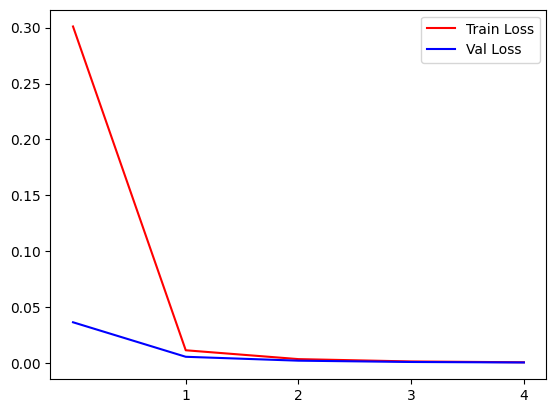

In [422]:
plt.plot(train_loss_1,c='r',label='Train Loss')
plt.plot(val_loss_1,c='b',label='Val Loss')
plt.xticks([1,2,3,4])
plt.legend()